In [1596]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
# dtype = torch.float
# #device = torch.device("cpu")
#device = torch.device("cuda:0")
# torch.set_default_tensor_type('torch.cuda.FloatTensor')
import NeuralNetwork as NN
import Layer
import importlib
import time
from IPython.display import display
from ipywidgets import FloatProgress
from copy import deepcopy

importlib.reload(NN)
importlib.reload(Layer);

In [1560]:
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=2))
#net.AddLayer(Layer.PELayer(n=2))
net.AddLayer(Layer.PELayer(n=2))
net.AddLayer(Layer.TopPELayer(n=2))
#net.layers[1].sigma = Layer.logistic
#net.layers[1].sigma_p = Layer.logistic_p

In [854]:
net.SetIdentityWeights()
net.M[0] += torch.normal( mean=torch.zeros_like(net.M[0]) )/2.
net.M[1] += torch.normal( mean=torch.zeros_like(net.M[1]) )/2.

In [1060]:
def RandomSample():
    amp = 0.5
    x = (2.*np.random.rand() - 1)*amp
    y = (2.*np.random.rand() - 1)*amp
    return [[x, y], [-y, -x]] #np.array([x, y], dtype=np.float64)

In [1561]:
def RandomSample():
    r = np.random.rand(2)
    x = np.round(r)*2. - 1
    y = deepcopy(x)
    return [x, y]

In [1569]:
net.learning_tau = 2.
epochs = 200
fp = FloatProgress(min=0,max=epochs)  
display(fp)
T = 5.
start_time = time.time()
for k in range(epochs):
    [x, y] = RandomSample()
    net.Infer(T, x, y)
    fp.value += 1
end_time = time.time()
print('Total time: '+str(end_time-start_time))

A Jupyter Widget

Total time: 21.609349012374878


In [1577]:
[x, y] = RandomSample()
#net.Reset()
yy = net.Predict(10., x)
print(y,np.array(yy))

[-1.  1.] [-0.94464964  0.9512184 ]


In [1584]:
[x, y] = RandomSample()
#net.Reset()
xx = net.Generate(10., y)
print(x,np.array(xx))

[1. 1.] [0.9524611 0.8613243]


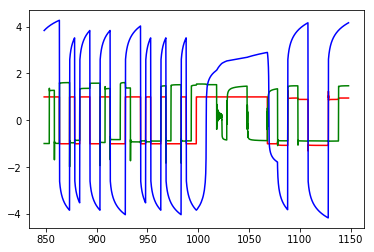

In [1586]:
lastn = -30*1000
#lastn = 0
plt.plot(np.array(net.t_history[lastn:]), np.array(net.layers[0].v_history)[lastn:,0], 'r',
         np.array(net.t_history[lastn:]), np.array(net.layers[1].v_history)[lastn:,0], 'g',
         np.array(net.t_history[lastn:]), np.array(net.layers[2].v_history)[lastn:,0], 'b');

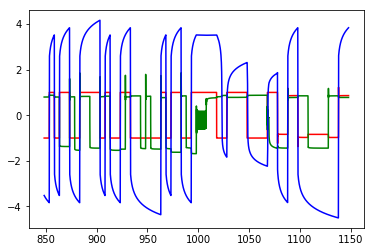

In [1587]:
plt.plot(np.array(net.t_history[lastn:]), np.array(net.layers[0].v_history)[lastn:,1], 'r',
         np.array(net.t_history[lastn:]), np.array(net.layers[1].v_history)[lastn:,1], 'g',
         np.array(net.t_history[lastn:]), np.array(net.layers[2].v_history)[lastn:,1], 'b');

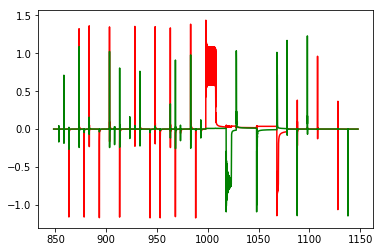

In [1588]:
plt.plot(np.array(net.t_history[lastn:]), np.array(net.layers[0].e_history)[lastn:,0], 'r',
         np.array(net.t_history[lastn:]), np.array(net.layers[1].e_history)[lastn:,0], 'g');
#plt.ylim([-0.01,0.01])

In [1591]:
# Test the feedback (generative) performance
beta = 0. # 1 for FF, 0 for FB
inf_layer = -1 if beta==1 else 0
n_trials = 20
x_true = []
x_est = []
T = 10.
for trial in range(n_trials):
    [x, y] = RandomSample()
    if beta==1:
        x_true.append(np.array(y))
        y = net.Predict(T, x)
        x_est.append(np.array(y))
    else:
        x_true.append(np.array(x))
        x = net.Generate(T, y)
        x_est.append(np.array(x))
x_true = np.array(x_true)
x_est = np.array(x_est)

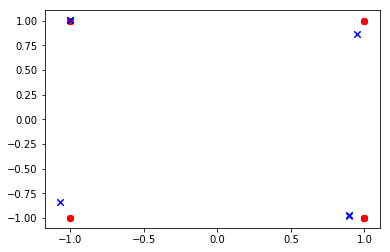

In [1592]:
plt.plot(x_true[:,0], x_true[:,1], 'ro', x_est[:,0], x_est[:,1], 'bx');